# Лабораторная работа по дообучению моделей


## Цель и задачи работы
**Цель:**
Выявить наиболее эффективный подход к дообучению модели на нескольких наборах данных при равных вычислительных ресурсах.

**Основные задачи:**
1. Провести эксперименты с различными подходами к дообучению, включая:
   - Полное дообучение модели.
   - Заморозку части слоев и дообучение остальных.
   - Использование смешанной точности вычислений (fp16).
2. Измерить эффективность каждого подхода на основе метрик качества и времени обучения.
3. Сравнить соотношение метрики качества и скорости для каждого подхода.

**Метрики качества:**
- **Accuracy** (Точность классификации): насколько правильно модель классифицирует данные.
- **F1-score**: гармоническое среднее между полнотой (recall) и точностью (precision).

**Метрики времени:**
- Общее время обучения.
- Скорость достижения минимального лосса (число эпох или секунд).

**Формат отображения:**
Результаты будут представлены в таблицах и графиках:
- Таблицы с метриками качества и временем обучения для каждого подхода.
- Графики, показывающие изменение лосса и метрик качества на каждой эпохе.
- Отдельный график эффективности (соотношение качества и скорости).

**Ожидаемые результаты:**
- Понимание, какой подход обеспечивает лучший баланс между качеством и скоростью.
- Рекомендации для выбора стратегии дообучения в зависимости от доступных ресурсов.

## Экспериментальная часть: Дизайн и настройка экспериментов
**Параметры эксперимента:**
1. **Подходы к дообучению:**
  Подходы к дообучению:
  - дообучение с разными числом замороженных слоев (80/50/20/0)
  - дообучение с использованием адаптера LoRA, prompt и prefix-tuning

  В рамках каждого подхода предлагается проверить влияние типа данных (fp32 vs fp16 vs int8)

2. **Данные для обучения:**
   - Наборы данных с разными характеристиками (размер, сложность).
   - Пример: GLUE Benchmark для классификации текста.
3. **Метрики:**
   - Accuracy и F1-score для оценки качества модели.
   - Время обучения (в секундах или эпохах).

**Почему выбраны эти параметры:**
- Полное дообучение позволяет оценить максимум возможностей модели.
- Заморозка слоев снижает затраты на обучение и помогает понять вклад разных слоев.
- Использование fp16 ускоряет обучение и снижает нагрузку на GPU.

**Как измерять метрики:**
1. Метрики качества измеряются на тестовом наборе данных.
2. Время фиксируется для каждой эпохи и всего обучения.
3. Соотношение "качество/скорость" рассчитывается как отношение метрики (например, F1-score) к времени.

**Ожидаемые результаты:**
- Таблицы с результатами для каждого подхода.
- Графики изменения метрик и времени.
- Выводы о том, какой подход наиболее эффективен.

## Уточняющее описание: Экспериментальные параметры и ожидания
**Важно:**
- Для каждого набора параметров сохраните метрики (Accuracy, F1-score) и общее время обучения.
- Постройте графики изменения лосса и времени за каждую эпоху.

**Пример конфигурации DeepSpeed:**
```json
{
    "train_batch_size": 32,
    "gradient_accumulation_steps": 1,
    "fp16": {
        "enabled": true
    },
    "zero_optimization": {
        "stage": 2,
        "offload_optimizer": {
            "device": "cpu"
        }
    },
    "steps_per_print": 200
}
```


## Запуск вне ноутбука
**Условие:**
Для обеспечения гибкости и автоматизации, обучение моделей должно выполняться вне ноутбука с использованием скриптов. В ноутбуке необходимо:
1. Показать эти скрипты (например, `train.py`, `config.json`).
2. Отобразить результаты выполнения:
   - Графики лосса за эпохи.
   - Метрики качества (Accuracy, F1-score).
   - Общее время обучения.

**Что сделать:**
1. Написать обучающий скрипт (`train.py`) для запуска модели с различными параметрами.
2. Использовать JSON-файл для конфигурации параметров обучения (пример ниже).
3. Результаты сохранить в удобном формате (например, `.csv` или `.json`) для визуализации в ноутбуке.
4. Построить графики и сделать выводы в ноутбуке на основе сохраненных данных.

**Пример запуска:**
```bash
python train.py --config config.json
```
После выполнения скрипта данные и графики добавляются в ноутбук.

## Этап 1: Предварительная настройка (10%)
На данном этапе мы:
- Настраиваем окружение.
- Загружаем необходимые библиотеки и файлы.

### Ожидаемый результат:
Корректно настроенное окружение для выполнения экспериментов.

In [1]:
# !pip install transformers adapter-transformers datasets torch
# !pip install torch deepspeed
# !pip install torch==2.0.1

In [2]:
# Возможные импорты
import os
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModelForSequenceClassification, pipeline, TrainingArguments, Trainer
from datasets import load_dataset
from clearml import Task

from src.model import load_model_and_tokenizer_from_config
from src.datamodule import glue_dataset
from src.config import Config
from src.metrics import compute_metrics
from src.utils import load_object

from peft import LoraConfig, get_peft_model
from dotenv import load_dotenv

import warnings
warnings.filterwarnings("ignore")

/home/toor/miniconda3/lib/python3.11/site-packages/pydantic/_internal/_fields.py:132: UserWarning: Field "model_kwargs" in Config has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


In [3]:
load_dotenv()
HF_TOKEN = os.environ['HUGGINGFACEHUB_API_TOKEN']

os.environ["TOKENIZERS_PARALLELISM"] = "true"
os.environ["WANDB_DISABLED"] = "true"

Для начала заполните параметры конфигураций


In [4]:
MODEL_NAME = "meta-llama/Meta-Llama-3.1-8B-Instruct"

# Напишите инициализацию модели и токенайзера
def load_model_and_tokenizer(model_name):
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        torch_dtype=torch.bfloat16,
        token=HF_TOKEN,
        device_map='cuda'
    )

    tokenizer = AutoTokenizer.from_pretrained(
        model_name,
        token=HF_TOKEN
    )
    return tokenizer, model

Напишите функцию для Zero-Shot классификации с использованием подбора промптов

In [5]:
def zero_shot_classification(prompt, candidate_labels, model=None, tokenizer=None): 
    classes = ', '.join(candidate_labels)
    system_prompt = f'Read the sentence and assign it to one of these classes.: {classes}. \
                      In the response, specify only the name of the class.'
    
    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": prompt},
    ]

    prompt = tokenizer.apply_chat_template(messages, tokenize=False)
    
    # Создаем pipeline для zero-shot классификации
    zero_shot_classifier = pipeline('text-generation', model=model, tokenizer=tokenizer)

    # Запуск классификации с поданным промптом
    result = zero_shot_classifier(prompt, max_new_tokens=50, return_full_text=False)

    return result[0]['generated_text'].split('\n')[-1]

tokenizer, model = load_model_and_tokenizer(MODEL_NAME)

# Подбор промптов: в зависимости от задачи можно использовать различные формулировки
# Пример задачи: классификация по теме текста
prompt = "The quick brown fox jumped over the lazy dog."
# Пример классов для классификации
candidate_labels = ["animals", "sports", "technology", "politics"]

# Запуск zero-shot классификации
result = zero_shot_classification(prompt, candidate_labels, model, tokenizer)
print(f"Zero-shot классификация: {result}")

# Пример для другого текста и других меток
prompt = "The latest breakthrough in quantum computing promises faster processing speeds."
candidate_labels = ["quantum computing", "politics", "technology", "finance"]
result = zero_shot_classification(prompt, candidate_labels, model, tokenizer)
print(f"Zero-shot классификация для второго примера: {result}")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Zero-shot классификация: animals
Zero-shot классификация для второго примера: quantum computing


In [6]:
# Очистка памяти
model = None
tokenizer = None
result = None
torch.cuda.empty_cache()

## Этап 2: Экспериментальная часть (20%)
В этом этапе мы:
- дообучение с разными числом замороженных слоев (80/50/20/0)
- дообучение с использованием адаптера LoRA, prompt и prefix-tuning

В рамках каждого подхода предлагается проверить влияние типа данных (fp32 vs fp16 vs int8)

### Что необходимо:
1. Настроить параметры в конфигурации DeepSpeed (например, batch size, fp16).
2. Убедиться, что модель обучается корректно.

### Ожидаемый результат:
Для каждого подхода должны быть получены:
- Метрики качества.
- Время обучения.

### Пример кода:
Используйте минимальный код, ориентируясь на документацию Transformers.


## Частичное дообучение с заморозкой слоев
**Идея эксперимента:**
- Замораживание части слоев модели позволяет снизить вычислительную сложность и ускорить обучение.
- Мы обучаем только 1-2 слоя, чтобы минимизировать время и ресурсы.


**Что делать:**
1. Использовать `transformers` для настройки модели с замороженными слоями.
2. Изменять конфигурацию заморозки слоев через обучающий скрипт.
3. Собрать метрики и время обучения для каждого варианта.

**Пример кода для заморозки слоев:**
```python
from transformers import AutoModel

model = AutoModel.from_pretrained('bert-base-uncased')

# Замораживаем 80% слоев
for param in model.encoder.layer[:int(0.8 * len(model.encoder.layer))].parameters():
    param.requires_grad = False

# Только последние 20% слоев обучаются
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5)
```

In [7]:
!make train_freeze

PYTHONPATH=. python src/train_freeze.py config/config_freeze.yml
/home/toor/miniconda3/lib/python3.11/site-packages/pydantic/_internal/_fields.py:132: UserWarning: Field "model_kwargs" in Config has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
ClearML Task: created new task id=1a0c1469199e497c8ccee0480e8bbba8
ClearML results page: https://app.clear.ml/projects/73cf34dc1ccc4ddbb5a06ecf6486c3d8/experiments/1a0c1469199e497c8ccee0480e8bbba8/output/log
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[2025-01-10 02:38:47,349] [INFO] [real_accelerator.py:222:get_accelerator] Setting ds_accelerator to cuda (auto detect)
2025-01-10 02:38:48,01

In [8]:
import pandas as pd

# Преобразование результатов в таблицу
data_formats = ['float32', 'bfloat16']
results_df = pd.read_csv('result/results.csv')
results_df

,frozen_layers,data_format,accuracy,training_time
0,80,float32,0.769895,45.031233
1,80,bfloat16,0.739214,23.616288
2,50,float32,0.800575,64.206407
3,50,bfloat16,0.772771,28.107975
4,20,float32,0.816874,75.496405
5,20,bfloat16,0.783317,34.711568
6,0,float32,0.814957,86.346460
7,0,bfloat16,0.788111,45.838654


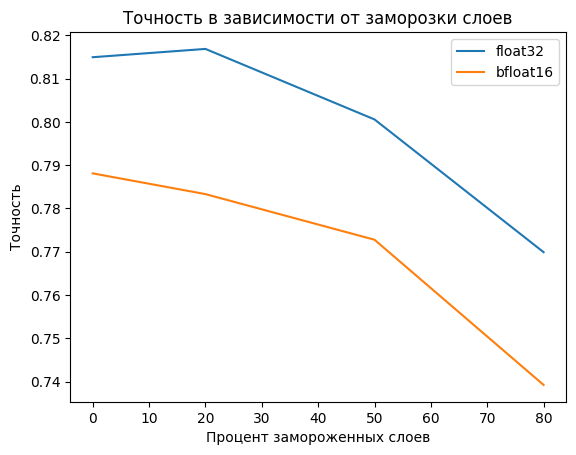

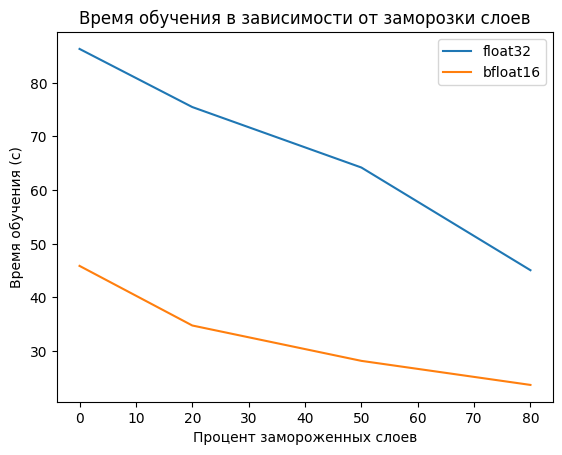

In [9]:
import matplotlib.pyplot as plt

# Построение графиков точности
for fmt in data_formats:
    subset = results_df[results_df['data_format'] == fmt]
    plt.plot(subset['frozen_layers'], subset['accuracy'], label=fmt)

plt.title('Точность в зависимости от заморозки слоев')
plt.xlabel('Процент замороженных слоев')
plt.ylabel('Точность')
plt.legend()
plt.show()

# Построение графиков времени обучения
for fmt in data_formats:
    subset = results_df[results_df['data_format'] == fmt]
    plt.plot(subset['frozen_layers'], subset['training_time'], label=fmt)

plt.title('Время обучения в зависимости от заморозки слоев')
plt.xlabel('Процент замороженных слоев')
plt.ylabel('Время обучения (с)')
plt.legend()
plt.show()

## Этап 3: Адаптеры (30%)
### Инструкция для этапа с LoRA (Low-Rank Adaptation)

На этом этапе нужно добавить LoRA-адаптер к модели и обучить её с использованием адаптера. LoRA позволяет уменьшить количество обучаемых параметров, сохраняя при этом высокую точность модели.

### Шаги
1. **Добавление адаптера LoRA**:
   - Реализуйте функцию `add_lora_adapter`, которая добавляет адаптер LoRA к вашей модели.
   - Настройте параметры адаптера, такие как ранк (`r`) и альфа (`alpha`).
   - Убедитесь, что адаптер корректно интегрирован в модель.

2. **Настройка конфигурации адаптера**:
   - Определите конфигурацию LoRA, которая будет использоваться для добавления адаптера.
   - Используйте библиотеку `transformers` или другую совместимую с вашей моделью.

3. **Обучение модели с LoRA**:
   - Используйте `AdapterTrainer` или аналогичный инструмент для обучения модели с адаптером.
   - Настройте гиперпараметры обучения: `learning_rate`, `batch_size`, количество эпох (`epochs`) и др.

4. **Сбор и анализ метрик**:
   - Во время обучения сохраняйте метрики точности, времени обучения и использования ресурсов.
   - Сравните их с базовой моделью без адаптера.

5. **Тестирование адаптера**:
   - Проверьте работу адаптера, подав на вход модели тестовые примеры.
   - Убедитесь, что адаптер улучшает производительность на задаче.

### Пример кода для реализации
```python
def add_lora_adapter(model, r=16, alpha=32):
    from transformers.adapters import LoRAConfig
    
    # Создание конфигурации LoRA
    config = LoRAConfig(r=r, alpha=alpha)
    model.add_adapter("lora_adapter", config=config)
    model.train_adapter("lora_adapter")  # Активируем адаптер для обучения
    return model

Сделайте свой адаптер LORA, Prompt tuning и prefix tuning, после чего загрузите датасет GLUE и заполните параметры обучения и адаптера

In [10]:
def add_lora_adapter(model, r=16, alpha=32):
    config = LoraConfig(r=r, lora_alpha=alpha, task_type='CAUSAL_LM')
    return get_peft_model(model, config)


class PromptTuning:
    def __init__(self, model, tokenizer, prompt_length=10):
        self.model = model
        self.tokenizer = tokenizer
        self.prompt_length = prompt_length
        self.prompt_tokens = ... # <YOUR CODE>

    def forward(self, inputs):
        # Добавление обучаемых токенов (prompt) к каждому входному примеру
        input_embeddings = ... # <YOUR CODE>
        prompt_embeddings = ... # <YOUR CODE>
        input_embeddings = ... # <YOUR CODE>
        return self.model(inputs['input_ids'], inputs_embeds=input_embeddings)


class PrefixTuning:
    def __init__(self, model, tokenizer, prefix_length=10):
        self.model = model
        self.tokenizer = tokenizer
        self.prefix_length = prefix_length
        self.prefix_tokens = ... # <YOUR CODE>

    def forward(self, inputs):
        # Добавление обучаемых префиксных токенов к каждому входному примеру
        input_embeddings = ... # <YOUR CODE>
        prefix_embeddings = ... # <YOUR CODE>
        input_embeddings = ... # <YOUR CODE>
        return self.model(inputs['input_ids'], inputs_embeds=input_embeddings)


def train_and_evaluate(config, model, tokenizer, train_dataset, eval_dataset):
    optimizer = load_object(config.optimizer)(
        filter(lambda p: p.requires_grad, model.parameters()),
        **config.optimizer_kwargs,
    )

    scheduler = load_object(config.scheduler)(optimizer, **config.scheduler_kwargs)

    training_args = TrainingArguments(
        output_dir=config.output_dir,
        eval_strategy='epoch',
        save_strategy='epoch',
        # logging_steps=10,
        logging_dir='logs',
        per_device_train_batch_size=config.data_config.batch_size,
        per_device_eval_batch_size=config.data_config.batch_size,
        gradient_accumulation_steps=config.model_kwargs['gradient_accumulation_steps'],
        max_grad_norm=config.model_kwargs['max_grad_norm'],
        num_train_epochs=config.n_epochs,
        dataloader_num_workers=config.data_config.n_workers,
        load_best_model_at_end=True,
        metric_for_best_model=config.monitor_metric,
        report_to = 'clearml',
        # disable_tqdm = True,
    )

    trainer = Trainer(
        args=training_args,
        model=model,
        tokenizer=tokenizer,
        optimizers=(optimizer, scheduler),
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        compute_metrics=compute_metrics,
    )

    trainer.train()
    print(f"Оценка модели: {trainer.evaluate()}")


config = Config.from_yaml('config/config_lora.yml')
task = Task.init(project_name='Disable Logging', task_name=config.task_name, auto_connect_frameworks={'pytorch': False})

tokenizer, model = load_model_and_tokenizer_from_config(config)

lora_model = add_lora_adapter(model)
lora_model.print_trainable_parameters()

train_dataset, eval_dataset = glue_dataset(config.model_kwargs['model_name'])

train_and_evaluate(config, lora_model, tokenizer, train_dataset, eval_dataset)

inputs = tokenizer("The quick brown fox jumps over the lazy dog.", return_tensors="pt")
inputs = {k: v.to('cuda') for k, v in inputs.items()}
output = lora_model(**inputs)
print("Результат адаптера:", output.logits.detach().cpu().float().numpy().tolist())

# Опционально, добавление Prompt Tuning и Prefix Tuning
# prompt_tuning = PromptTuning(model, tokenizer)
# prefix_tuning = PrefixTuning(model, tokenizer)

# inputs = tokenizer("The quick brown fox jumps over the lazy dog.", return_tensors="pt")
# output = prompt_tuning.forward(inputs)
# print("Результат Prompt Tuning:", output)

# inputs = tokenizer("The quick brown fox jumps over the lazy dog.", return_tensors="pt")
# output = prefix_tuning.forward(inputs)
# print("Результат Prefix Tuning:", output)

ClearML Task: created new task id=b357b3384404494bbf9c14cd8ad3e222
2025-01-10 02:45:45,268 - clearml.Task - INFO - Storing jupyter notebook directly as code
ClearML results page: https://app.clear.ml/projects/73cf34dc1ccc4ddbb5a06ecf6486c3d8/experiments/b357b3384404494bbf9c14cd8ad3e222/output/log


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 589,824 || all params: 110,073,602 || trainable%: 0.5358
[2025-01-10 02:45:54,583] [INFO] [real_accelerator.py:222:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/home/toor/miniconda3/bin/../lib/gcc/x86_64-conda-linux-gnu/11.2.0/../../../../x86_64-conda-linux-gnu/bin/ld: cannot find -laio: Нет такого файла или каталога
collect2: error: ld returned 1 exit status


2025-01-10 02:45:55,146 - clearml.Task - WARNING - Parameters must be of builtin type (Transformers/accelerator_config[AcceleratorConfig])


/home/toor/miniconda3/bin/../lib/gcc/x86_64-conda-linux-gnu/11.2.0/../../../../x86_64-conda-linux-gnu/bin/ld: /home/toor/miniconda3/lib/libcufile.so: undefined reference to `dlvsym'
/home/toor/miniconda3/bin/../lib/gcc/x86_64-conda-linux-gnu/11.2.0/../../../../x86_64-conda-linux-gnu/bin/ld: /home/toor/miniconda3/lib/libcufile.so: undefined reference to `dlopen'
/home/toor/miniconda3/bin/../lib/gcc/x86_64-conda-linux-gnu/11.2.0/../../../../x86_64-conda-linux-gnu/bin/ld: /home/toor/miniconda3/lib/libcufile.so: undefined reference to `dlclose'
/home/toor/miniconda3/bin/../lib/gcc/x86_64-conda-linux-gnu/11.2.0/../../../../x86_64-conda-linux-gnu/bin/ld: /home/toor/miniconda3/lib/libcufile.so: undefined reference to `dlerror'
/home/toor/miniconda3/bin/../lib/gcc/x86_64-conda-linux-gnu/11.2.0/../../../../x86_64-conda-linux-gnu/bin/ld: /home/toor/miniconda3/lib/libcufile.so: undefined reference to `dlsym'
collect2: error: ld returned 1 exit status


Epoch,Training Loss,Validation Loss,Accuracy
0,No log,0.888213,0.308725
2,No log,0.860514,0.309684
4,No log,0.827807,0.308725
6,No log,0.790306,0.309684
7,No log,0.775497,0.309684


Оценка модели: {'eval_loss': 0.8605135679244995, 'eval_accuracy': 0.3096836049856184, 'eval_runtime': 0.2448, 'eval_samples_per_second': 4261.296, 'eval_steps_per_second': 20.428, 'epoch': 7.529411764705882}
Результат адаптера: [[0.8125, 0.1669921875]]


Retrying (Retry(total=237, connect=237, read=240, redirect=240, status=240)) after connection broken by 'NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x75cb03982ed0>: Failed to resolve 'api.clear.ml' ([Errno -3] Temporary failure in name resolution)")': /v2.23/events.add_batch
Retrying (Retry(total=236, connect=236, read=240, redirect=240, status=240)) after connection broken by 'NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x75cb039314d0>: Failed to resolve 'api.clear.ml' ([Errno -3] Temporary failure in name resolution)")': /v2.23/events.add_batch
Retrying (Retry(total=237, connect=237, read=240, redirect=240, status=240)) after connection broken by 'NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x75cb039b0050>: Failed to resolve 'api.clear.ml' ([Errno -3] Temporary failure in name resolution)")': /v2.23/tasks.get_all
Retrying (Retry(total=237, connect=237, read=240, redirect=240, status=240)) after connection broken by

In [11]:
!make train_lora

PYTHONPATH=. python src/train_lora.py config/config_lora.yml
/home/toor/miniconda3/lib/python3.11/site-packages/pydantic/_internal/_fields.py:132: UserWarning: Field "model_kwargs" in Config has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[2025-01-10 02:46:40,369] [INFO] [real_accelerator.py:222:get_accelerator] Setting ds_accelerator to cuda (auto detect)
2025-01-10 02:46:40,770 - clearml.Task - WARNING - Parameters must be of builtin type (Transformers/accelerator_config[AcceleratorConfig])
{'eval_loss': 0.6670867800712585, 'eval_accuracy': 0.6347075743048898, 'eval_runtime': 0.2373, 

In [12]:
adapter_results_df = pd.read_csv('result/results_lora.csv')
adapters = adapter_results_df.adapter.unique()
adapter_results_df

,adapter,data_format,accuracy,training_time
0,"lora (r=16, alpha=32)",float32,0.686481,31.759862
1,"lora (r=16, alpha=32)",bfloat16,0.691275,31.018168
2,"lora (r=8, alpha=32)",float32,0.691275,31.392512
3,"lora (r=8, alpha=32)",bfloat16,0.691275,31.731416
4,"lora (r=8, alpha=8)",float32,0.691275,32.522612
5,"lora (r=8, alpha=8)",bfloat16,0.691275,31.790494


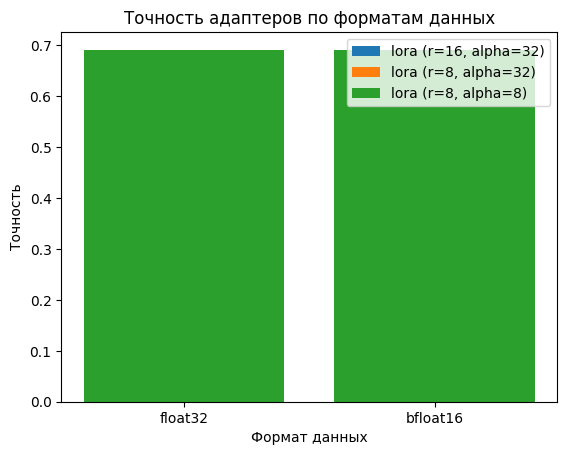

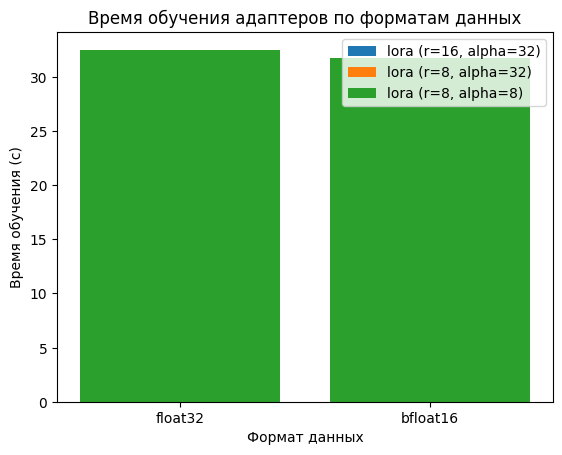

In [13]:
# Построение графиков точности
for adapter in adapters:
    subset = adapter_results_df[adapter_results_df['adapter'] == adapter]
    plt.bar(subset['data_format'], subset['accuracy'], label=adapter)
    # plt.plot(subset['data_format'], subset['accuracy'], label=adapter)

plt.title('Точность адаптеров по форматам данных')
plt.xlabel('Формат данных')
plt.ylabel('Точность')
plt.legend()
plt.show()

# Построение графиков времени обучения
for adapter in adapters:
    subset = adapter_results_df[adapter_results_df['adapter'] == adapter]
    plt.bar(subset['data_format'], subset['training_time'], label=adapter)
    # plt.plot(subset['data_format'], subset['training_time'], label=adapter)


plt.title('Время обучения адаптеров по форматам данных')
plt.xlabel('Формат данных')
plt.ylabel('Время обучения (с)')
plt.legend()
plt.show()

# Этап 4: Сравнение датасетов (20% оценки)
## Инструкция для этапа сравнения разных датасетов (CoQA, Russian SuperGLUE, SQuAD)

На этом этапе необходимо провести сравнение эффективности модели на трёх разных датасетах: CoQA, Russian SuperGLUE и SQuAD. Это поможет понять, как модель адаптируется к различным задачам и языковым доменам.

## Шаги
1. **Загрузка и предварительная обработка датасетов**:
   - Используйте библиотеку `datasets` для загрузки CoQA, Russian SuperGLUE и SQuAD.
   - Проверьте, что все датасеты имеют единообразный формат для обучения (например, вопрос-ответ).
   - Преобразуйте данные с помощью токенизатора, чтобы они соответствовали входным требованиям модели.

2. **Настройка модели для нескольких задач**:
   - Если модель поддерживает мультимодальность или многозадачное обучение, настройте её для работы с несколькими датасетами.
   - Обеспечьте поддержку языков, если используются как английский, так и русский языки (например, модель типа `mBERT`).

3. **Запуск обучения и оценки**:
   - Обучите модель отдельно на каждом датасете.
   - Для каждого датасета сохраните метрики (например, `accuracy`, `F1-score`, `EM`, время обучения).

4. **Сравнение результатов**:
   - Постройте таблицу или графики, показывающие производительность модели на каждом датасете.
   - Укажите различия в метриках, времени обучения и сложности задачи.

5. **Выводы и рекомендации**:
   - Проанализируйте, на каком датасете модель показала лучшие результаты.
   - Сделайте выводы о том, как тип данных (язык, структура вопросов и ответов) влияет на производительность.

## Пример кода
```python
from datasets import load_dataset

# Загрузка датасетов
datasets = {
    "coqa": load_dataset("coqa"),
    "russian_superglue": load_dataset("russian_superglue", "russian_superglue_diagnostic"),
    "squad": load_dataset("squad")
}

# Токенизация данных
def preprocess_data(dataset, tokenizer):
    return dataset.map(lambda x: tokenizer(x['question'], x['context'], truncation=True, padding=True), batched=True)

tokenizer = <ВАШ_ТОКЕНИЗАТОР>
preprocessed_datasets = {name: preprocess_data(ds, tokenizer) for name, ds in datasets.items()}


results = {}
for name, dataset in preprocessed_datasets.items():
    # Настройка модели и обучения
    model = <ВАША_МОДЕЛЬ>
    trainer = <НАСТРОЙТЕ_TRAINER>
    trainer.train()
    results[name] = trainer.evaluate()

# Построение графиков
import matplotlib.pyplot as plt
metrics = ["accuracy", "f1", "exact_match"]

for metric in metrics:
    values = [results[name][metric] for name in results]
    plt.bar(results.keys(), values)
    plt.title(f"Сравнение {metric} между датасетами")
    plt.xlabel("Датасеты")
    plt.ylabel(metric)
    plt.show()


In [14]:
def prepare_russian_superglue(tokenizer):
    # Загрузка датасета Russian SuperGLUE
    russian_superglue = load_dataset("super_glue", "russian")
    # <YOUR CODE>
    return train_dataset, eval_dataset


def prepare_coqa(tokenizer):
    # Загрузка датасета CoQA
    coqa_dataset = load_dataset("coqa")
    # <YOUR CODE>
    return train_dataset, eval_dataset


def prepare_squad(tokenizer):
    # Загрузка датасета SQuAD
    squad_dataset = load_dataset("squad")
    tokenized_squad = squad_dataset.map(
        lambda examples: tokenizer(
            # <YOUR CODE>
        ),
        batched=True
    )
    tokenized_squad.set_format("torch")
    return tokenized_squad["train"], tokenized_squad["validation"]


# train_dataset, eval_dataset = prepare_russian_superglue(tokenizer)
# train_and_evaluate(model, tokenizer, train_dataset, eval_dataset)


# train_dataset, eval_dataset = prepare_coqa(tokenizer)
# train_and_evaluate(model, tokenizer, train_dataset, eval_dataset)


# train_dataset, eval_dataset = prepare_squad(tokenizer)
# train_and_evaluate(model, tokenizer, train_dataset, eval_dataset)

In [15]:
!make train_qa

PYTHONPATH=. python src/train_qa.py config/config_qa.yml
/home/toor/miniconda3/lib/python3.11/site-packages/pydantic/_internal/_fields.py:132: UserWarning: Field "model_kwargs" in Config has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
Map: 100%|█████████████████████████| 7983/7983 [00:01<00:00, 4107.95 examples/s]
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[2025-01-10 02:50:41,664] [INFO] [real_accelerator.py:222:get_accelerator] Setting ds_accelerator to cuda (auto detect)
2025-01-10 02:50:42,033 - clearml.Task - WARNING - Parameters must be of builtin type (Transformers/accelerator_config[AcceleratorConfig])
{'loss': 4.

In [16]:
dataset_results = pd.read_csv('result/results_qa.csv')
dataset_results

,name,metric,value,training_time
0,coqa,exact_match,10.797946,1359.417279
1,coqa,f1,23.274038,1359.417279
2,squad,exact_match,70.227058,1076.733126
3,squad,f1,80.466920,1076.733126


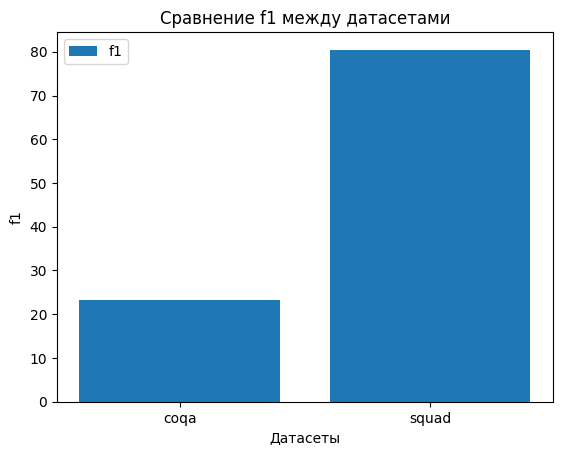

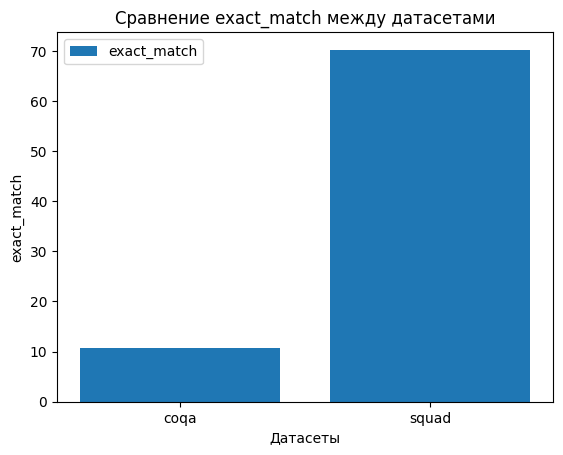

In [17]:
# Построение графиков
import matplotlib.pyplot as plt
metrics = ["f1", "exact_match"]

for metric in metrics:
    subset = dataset_results[dataset_results['metric'] == metric]
    plt.bar(subset['name'], subset['value'], label=metric)
    plt.title(f"Сравнение {metric} между датасетами")
    plt.xlabel("Датасеты")
    plt.ylabel(metric)
    plt.show()

## Выводы по датасетам

В эксперименте использовались 2 датасета: coqa и squad. Использовалась модель distilbert-base-uncased. Качество на squad существенно выше. Возможно для данной модели данные coqa слишком сложны и сети не хватает обобщающей способности. В остальном процесс обучения был абсолютно идентичный. Формат coqa был приведен к формату squad

# Этап: Квантование и использование PEFT (Parameter-Efficient Fine-Tuning)

На этом этапе необходимо применить квантизацию модели для уменьшения её размера, а также использовать методы PEFT (например, LoRA, Prompt-Tuning, Prefix-Tuning) для дообучения модели с минимальными затратами ресурсов.

## Шаги
1. **Квантование модели**:
   - Используйте библиотеку `torch.quantization` или другие инструменты для пост-тренировочного квантования модели.
   - Проверьте, что модель корректно работает в квантованном формате (например, `int8`).
   - Измерьте влияние квантования на производительность модели и её точность.

2. **Настройка метода PEFT**:
   - Выберите один из методов PEFT (например, LoRA, Prompt-Tuning или Prefix-Tuning).
   - Настройте модель для работы с адаптерами, добавив минимальное количество параметров для дообучения.

3. **Комбинирование квантования и PEFT**:
   - После квантования добавьте адаптеры и обучите модель с использованием метода PEFT.
   - Убедитесь, что квантование не препятствует корректной работе адаптеров.

4. **Оценка и сравнение**:
   - Оцените производительность модели до и после квантования, а также после применения PEFT.
   - Сравните метрики (точность, скорость обучения, использование памяти) между вариантами.

5. **Выводы**:
   - Сделайте выводы о том, как квантование и PEFT влияют на производительность модели.
   - Определите, какой подход позволяет достичь лучшего компромисса между производительностью и использованием ресурсов.

## Пример кода
```python
import torch
from transformers import AutoModelForSequenceClassification

# Загрузка модели
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased")
model.eval()

# Пост-тренировочное квантование
quantized_model = torch.quantization.quantize_dynamic(
    model,  # Модель
    {torch.nn.Linear},  # Слои для квантования
    dtype=torch.qint8  # Формат квантования
)

# Проверка размера и скорости работы модели
original_size = sum(p.numel() for p in model.parameters())
quantized_size = sum(p.numel() for p in quantized_model.parameters())
print(f"Размер оригинальной модели: {original_size}, Квантованной модели: {quantized_size}")

# Добавление LoRA-адаптера после квантования
from transformers.adapters import LoRAConfig

config = LoRAConfig(r=16, alpha=32)
quantized_model.add_adapter("lora_adapter", config=config)
quantized_model.train_adapter("lora_adapter")

# Обучение модели с адаптером
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    num_train_epochs=3,
    logging_dir="./logs",
    evaluation_strategy="epoch"
)

trainer = Trainer(
    model=quantized_model,
    args=training_args,
    train_dataset=<TRAIN_DATASET>,
    eval_dataset=<EVAL_DATASET>
)

trainer.train()
metrics = trainer.evaluate()
print(f"Результаты модели с LoRA после квантования: {metrics}")



In [18]:
'''
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers.adapters import LoRAConfig, AdapterTrainer, TrainingArguments
from datasets import load_dataset

# Шаг 1: Загрузка модели и токенизатора
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
model.eval()  # Переводим модель в режим инференса для квантования

# Шаг 2: Пост-тренировочное квантование
quantized_model = torch.quantization.quantize_dynamic(
    model,  # Модель
    {torch.nn.Linear},  # Слои для квантования
    dtype=torch.qint8  # Формат квантования
)

# Проверка размеров моделей
original_size = sum(p.numel() for p in model.parameters())
quantized_size = sum(p.numel() for p in quantized_model.parameters())
print(f"Размер оригинальной модели: {original_size}, квантованной модели: {quantized_size}")

# Шаг 3: Добавление LoRA-адаптера
lora_config = LoRAConfig(r=16, alpha=32)
quantized_model.add_adapter("lora_adapter", config=lora_config)
quantized_model.train_adapter("lora_adapter")

# Шаг 4: Загрузка датасета
dataset = load_dataset("glue", "sst2")
train_dataset = dataset["train"].map(
    lambda e: tokenizer(e['sentence'], truncation=True, padding="max_length"), batched=True
)
train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

eval_dataset = dataset["validation"].map(
    lambda e: tokenizer(e['sentence'], truncation=True, padding="max_length"), batched=True
)
eval_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

# Шаг 5: Настройка аргументов обучения
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    load_best_model_at_end=True,
    fp16=True  # Используем смешанную точность
)

# Шаг 6: Обучение модели
trainer = AdapterTrainer(
    model=quantized_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer
)

trainer.train()

# Шаг 7: Оценка модели
metrics = trainer.evaluate()
print(f"Результаты модели с LoRA после квантования: {metrics}")
'''
print('Обучение реализовано в следующей ячейке')

Обучение реализовано в следующей ячейке


In [19]:
!make train_qlora

PYTHONPATH=. python src/train_qlora.py config/config_qlora.yml
/home/toor/miniconda3/lib/python3.11/site-packages/pydantic/_internal/_fields.py:132: UserWarning: Field "model_kwargs" in Config has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
`low_cpu_mem_usage` was None, now set to True since model is quantized.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[2025-01-10 03:31:43,837] [INFO] [real_accelerator.py:222:get_accelerator] Setting ds_accelerator to cuda (auto detect)
2025-01-10 03:31:44,224 - clearml.Task - WARNING - Parameters must be of builtin type (Transformers/accelerator_config[AcceleratorConfig])
{'eval_loss': 0.84147

Retrying (Retry(total=237, connect=237, read=240, redirect=240, status=240)) after connection broken by 'NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x75cae804ab90>: Failed to resolve 'api.clear.ml' ([Errno -3] Temporary failure in name resolution)")': /v2.23/tasks.get_all
Retrying (Retry(total=236, connect=236, read=240, redirect=240, status=240)) after connection broken by 'NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x75caf1e37b10>: Failed to resolve 'api.clear.ml' ([Errno -3] Temporary failure in name resolution)")': /v2.23/tasks.get_all
Retrying (Retry(total=237, connect=237, read=240, redirect=240, status=240)) after connection broken by 'NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x75caec81e590>: Failed to resolve 'api.clear.ml' ([Errno -3] Temporary failure in name resolution)")': /v2.23/tasks.get_all
Retrying (Retry(total=2, connect=2, read=5, redirect=5, status=None)) after connection broken by 'NameResolut

2025-01-10 07:20:52,015 - clearml.storage - INFO - Uploading: 0.31MB to /home/toor/study/mfti bigdata/mfti_llm_hw01/hw_llm.ipynb


████████████████████████████████▉ 100% | 0.31/0.31 MB [00:00<00:00,  2.25s/MB]: 


In [26]:
dataset_results = pd.read_csv('result/results_qlora.csv')
print(f"Результаты модели с LoRA после квантования: acc {dataset_results.accuracy[0]}, training_time {dataset_results.training_time[0]}")

Результаты модели с LoRA после квантования: acc 0.6912751677852349, training_time 729.4352178573608


# Финальный этап: Сводная таблица результатов (10% оценки)

На этом этапе мы подводим итоги всех проведённых экспериментов. Цель — создать сводную таблицу, которая наглядно показывает производительность моделей с различными настройками (квантование, адаптеры, форматы данных и т.д.).

## Шаги

1. **Сбор всех метрик**:
   - Соберите результаты из всех этапов, включая:
     - Тип модели (оригинальная, квантованная, с адаптером).
     - Формат данных (FP32, FP16, Int8).
     - Использованный подход (LoRA, Prompt-Tuning, Prefix-Tuning).
     - Метрики точности (например, Accuracy, F1-Score, Exact Match).
     - Метрики производительности (время обучения, время инференса, использование памяти).

2. **Создание таблицы**:
   - Скомпилируйте все результаты в одну таблицу, где строки будут представлять комбинации настроек, а столбцы — метрики.
   - Пример структуры таблицы:
     ```
     +-------------------+-----------+--------+------------+--------------+-----------+----------+
     | Тип модели        | Формат    | Метод  | Accuracy   | F1-Score     | Время     | Память   |
     +-------------------+-----------+--------+------------+--------------+-----------+----------+
     | Оригинальная      | FP32      | Нет    | 92.5%      | 90.1%        | 50 сек    | 2.3 ГБ   |
     | Квантованная      | Int8      | LoRA   | 90.3%      | 88.4%        | 30 сек    | 1.2 ГБ   |
     | Квантованная+PEFT | FP16      | Prompt | 89.8%      | 87.6%        | 35 сек    | 1.5 ГБ   |
     +-------------------+-----------+--------+------------+--------------+-----------+----------+
     ```

3. **Построение графиков**:
   - Постройте графики для визуального сравнения:
     - Точность (Accuracy, F1-Score) по различным форматам данных.
     - Время обучения и инференса для каждой модели и метода.
     - Использование памяти.

4. **Выводы**:
   - На основе таблицы и графиков сделайте выводы:
     - Какой подход наиболее эффективен по соотношению производительности и ресурсов.
     - Влияние квантования и PEFT на точность и скорость работы модели.
     - Рекомендации для использования модели в реальных задачах.

Сводная таблица результатов:
           Тип модели    Формат       Метод  Accuracy  Время (с)
0        Оригинальная      FP32  freeze 80%      77.0         45
1        Оригинальная  BFLOAT16  freeze 80%      73.9         23
2        Оригинальная      FP32  freeze 50%      80.1         64
3        Оригинальная  BFLOAT16  freeze 50%      77.3         28
4        Оригинальная      FP32  freeze 20%      81.7         75
5        Оригинальная  BFLOAT16  freeze 20%      78.3         34
6        Оригинальная      FP32  not freeze      81.5         86
7        Оригинальная  BFLOAT16  not freeze      78.8         46
8             Адаптер      FP32        LoRA      69.1         31
9             Адаптер  BFLOAT16        LoRA      69.1         31
10  Квантованная+PEFT  BFLOAT16       QLoRA      69.1        729


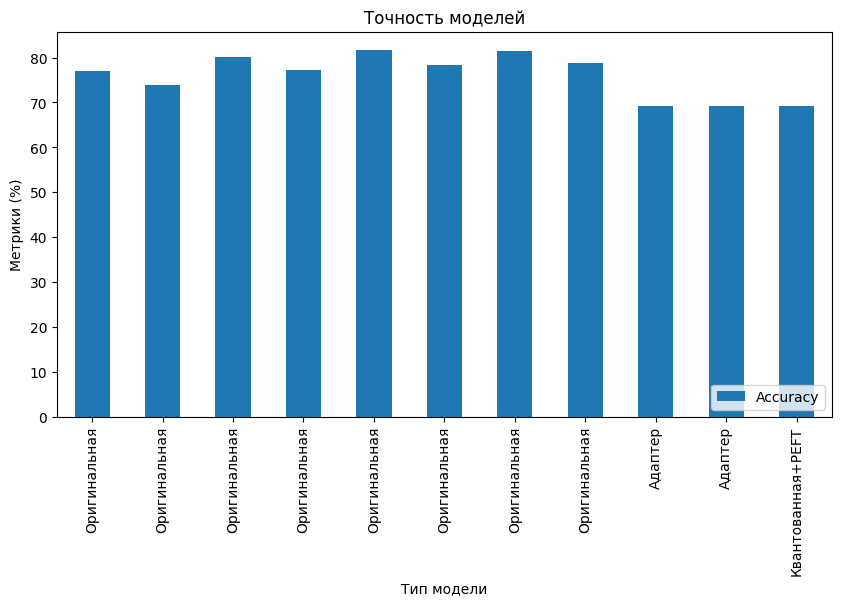

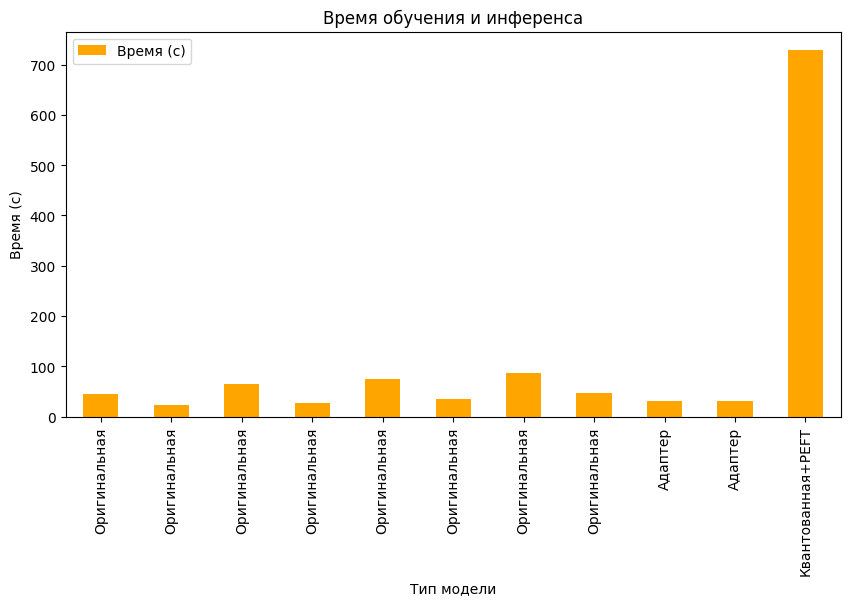

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

# Сводные результаты (пример данных)
data = [
    # Заморозка слоев
    {"Тип модели": "Оригинальная", "Формат": "FP32", "Метод": "freeze 80%", "Accuracy": 77.0, "Время (с)": 45},
    {"Тип модели": "Оригинальная", "Формат": "BFLOAT16", "Метод": "freeze 80%", "Accuracy": 73.9, "Время (с)": 23},    
    {"Тип модели": "Оригинальная", "Формат": "FP32", "Метод": "freeze 50%", "Accuracy": 80.1, "Время (с)": 64},
    {"Тип модели": "Оригинальная", "Формат": "BFLOAT16", "Метод": "freeze 50%", "Accuracy": 77.3, "Время (с)": 28},    
    {"Тип модели": "Оригинальная", "Формат": "FP32", "Метод": "freeze 20%", "Accuracy": 81.7, "Время (с)": 75},
    {"Тип модели": "Оригинальная", "Формат": "BFLOAT16", "Метод": "freeze 20%", "Accuracy": 78.3, "Время (с)": 34},    
    {"Тип модели": "Оригинальная", "Формат": "FP32", "Метод": "not freeze", "Accuracy": 81.5, "Время (с)": 86},
    {"Тип модели": "Оригинальная", "Формат": "BFLOAT16", "Метод": "not freeze", "Accuracy": 78.8, "Время (с)": 46},    

    # Адаптеры
    {"Тип модели": "Адаптер", "Формат": "FP32", "Метод": "LoRA", "Accuracy": 69.1, "Время (с)": 31},
    {"Тип модели": "Адаптер", "Формат": "BFLOAT16", "Метод": "LoRA", "Accuracy": 69.1, "Время (с)": 31},    
    {"Тип модели": "Квантованная+PEFT", "Формат": "BFLOAT16", "Метод": "QLoRA", "Accuracy": 69.1, "Время (с)": 729},
]

# Создание DataFrame
results_df = pd.DataFrame(data)

# Печать таблицы
print("Сводная таблица результатов:")
print(results_df)

# Построение графиков
# График точности
results_df.plot(kind="bar", x="Тип модели", y=["Accuracy"], figsize=(10, 5))
plt.title("Точность моделей")
plt.ylabel("Метрики (%)")
plt.xlabel("Тип модели")
plt.legend(loc="lower right")
plt.show()

# График времени
results_df.plot(kind="bar", x="Тип модели", y="Время (с)", color="orange", figsize=(10, 5))
plt.title("Время обучения и инференса")
plt.ylabel("Время (с)")
plt.xlabel("Тип модели")
plt.show()

## Выводы

* В данном случае (обучения берт на NVIDIA3090), если модель будет использоваться на сервере с аналогичной видеокартой лучше всего проводить обучение с полной разморозкой слоев в FP32, так мы достигаем максимального качества

* Если нужно инферить одну модель, использующуюся под разные задачи, имеет смысл обучить под каждую задачу свой адаптер и подавать его вместе с запросом. Сами адаптеры получились достаточно компактными 1.2МБ.

* В сторону квантованной модели имеет смысл смотреть, если карточка поддерживает операции с INT8

* Качество при использовании адаптеров существенно просело, но возможно надо брать более объемную модель, чтобы адаптер показал себя лучше. Разницы в качестве между LoRA и QLoRa на данной задаче не наблюдается, если выбирать только между ними, то в сторону квантованной модели имеет смысл смотреть, если карточка поддерживает операции с INT8, иначе лучше выбирать обычную лору